<a href="https://colab.research.google.com/github/vaibhavsundharam/Face-landmark-detection-and-adding-filters/blob/master/Facial_landmark_detection_and_adding_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![picture](https://drive.google.com/uc?export=view&id=1mygtGwbAU3eXzur5Uk3dlUModq4sCUXb)



Following code helps to detect key landmark locations on a face.





#Setting up environment

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import dlib
from google.colab.patches import cv2_imshow
import torchvision.transforms as transforms
import pandas as pd
import torch
import imutils
from math import hypot
import random
import math

In [ ]:
detector=dlib.get_frontal_face_detector() # face detector
model_path="/content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/Face landmark detection and adding filters/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(model_path)

# Add Glasses

In [ ]:
def add_glasses(face_img,  landmarks, glasses_list):
      overlay_t_img  = cv2.imread(random.choice(glasses_list), -1) # randomly selecting a nose image with transparent background
      # eye co-ordiantes
      eye_left = (landmarks.part(0).x, landmarks.part(0).y)
      eye_right = (landmarks.part(16).x, landmarks.part(16).y)
      eye_center = (landmarks.part(28).x, landmarks.part(28).y)
      glasses_width = int(np.floor(hypot(eye_left[0]-eye_right[0], eye_left[1] - eye_right[1])))    
      glasses_height = int(np.floor(glasses_width*(overlay_t_img.shape[0]/overlay_t_img.shape[1])))      
      roi_top_left =  (abs(int(eye_center[0] - glasses_width/2)),abs(int(eye_center[1] - glasses_height/2)))
      roi_bottom_right = (abs(int(eye_center[0] + glasses_width/2)), abs(int(eye_center[1] + glasses_height/2)))
      roi =  face_img[roi_top_left[1]: roi_top_left[1] + glasses_height, roi_top_left[0]: roi_top_left[0]+glasses_width]
      overlay_t_img = cv2.resize(overlay_t_img, (roi.shape[1], roi.shape[0]))        
      # Split out the transparency mask from the colour info
      overlay_mask = overlay_t_img[: , : , 3:]  # And the alpha plane  
      overlay_img = overlay_t_img[: , : , :3] # Grab the BRG planes
      # Let's shrink and blur it a little to make the transitions smoother...
      overlay_mask = cv2.erode(overlay_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
      overlay_mask = cv2.blur(overlay_mask, (3, 3))    
      # Again calculate the inverse mask
      background_mask = np.subtract(255,overlay_mask)           
      # Turn the masks into three channel, so we can use them as weights      
      overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
      background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)    
      # Create a masked out face image, and masked out overlay
      # We convert the images to floating point in range 0.0 - 1.0 
      face_part = face_part = (roi  * (background_mask * (1 / 255.0)))  
      overlay_part = (overlay_img * (overlay_mask * (1 / 255.0)))
      dst = cv2.add(face_part,overlay_part)
      face_img[roi_top_left[1]: roi_top_left[1] + glasses_height, roi_top_left[0]: roi_top_left[0]+glasses_width]=dst           
      return face_img
    # ==============================================================================

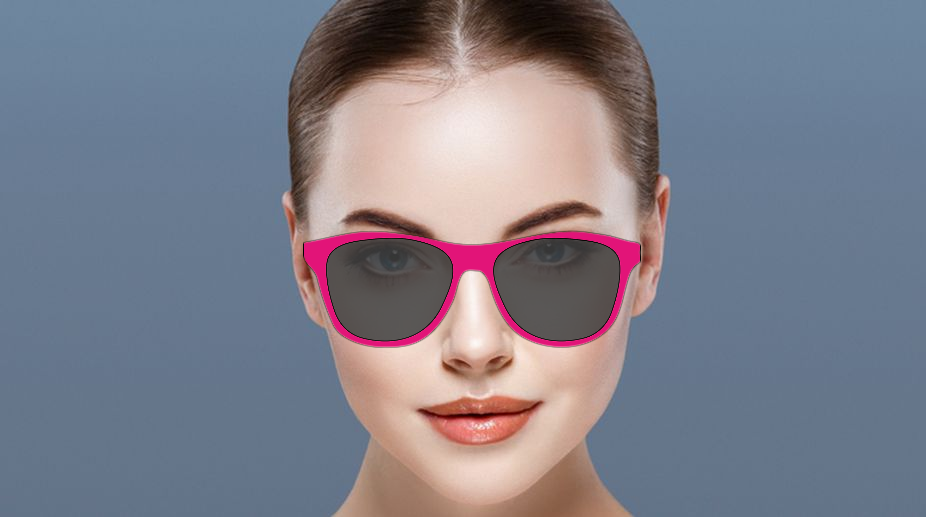

In [ ]:
glasses_list=["/content/30.png"] # list of sunglasses
img = cv2.imread("/content/face.jpg")

face = detector(img, 1) # detecting face in the image, note--> if face.jpg has multiple faces it will detect all and apply the filter to each of the faces in the image


for face in face: # irerating over each face in the image (face.jpg) 
  landmarks = predictor(img, face) # predicting landmarks for the detected face, in this case only one
  result_2 = add_glasses(img, landmarks= landmarks, glasses_list= glasses_list) # adding filter
  cv2_imshow(result_2)
  

#Add Nose

In [ ]:
def add_nose(face_img,  landmarks, nose_list):
      overlay_t_img  = cv2.imread(random.choice(nose_list), -1) # randomly selecting a nose image with transparent background
      # Nose co-ordinate
      nose_top = (landmarks.part(29).x, landmarks.part(29).y)
      nose_center = (landmarks.part(30).x, landmarks.part(30).y)
      nose_left = (landmarks.part(31).x, landmarks.part(31).y)
      nose_right = (landmarks.part(35).x, landmarks.part(35).y)
      nose_bottom = (landmarks.part(33).x, landmarks.part(33).y)
      nose_width = int(hypot(nose_left[0] - nose_right[0], nose_left[1] - nose_right[1]) * 1.2)
      nose_height = int(nose_width*(overlay_t_img.shape[0]/overlay_t_img.shape[1]))
      roi_top_left =  (abs(int(nose_center[0] - nose_width/2)), abs(int(nose_center[1] - nose_height/2)))
      roi_bottom_right = (abs(int(nose_center[0] + nose_width/2)), abs(int(nose_center[1] + nose_height/2)))
      roi =  face_img[roi_top_left[1]: roi_top_left[1] + nose_height, roi_top_left[0]: roi_top_left[0]+nose_width]
      overlay_t_img = cv2.resize(overlay_t_img, (roi.shape[1], roi.shape[0]))          
      # Split out the transparency mask from the colour info
      overlay_mask = overlay_t_img[: , : , 3:]  # And the alpha plane  
      overlay_img = overlay_t_img[: , : , :3] # Grab the BRG planes
      # Let's shrink and blur it a little to make the transitions smoother...
      overlay_mask = cv2.erode(overlay_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
      overlay_mask = cv2.blur(overlay_mask, (3, 3))          
      # Again calculate the inverse mask
      background_mask = 255 - overlay_mask              
      # Turn the masks into three channel, so we can use them as weights
      overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
      background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)          
      # Create a masked out face image, and masked out overlay
      # We convert the images to floating point in range 0.0 - 1.0
      face_part = face_part = (roi  * (background_mask * (1 / 255.0)))
      overlay_part = (overlay_img * (overlay_mask * (1 / 255.0)))    
      dst = cv2.add(face_part,overlay_part)
      face_img[roi_top_left[1]: roi_top_left[1] + nose_height, roi_top_left[0]: roi_top_left[0]+nose_width] = dst          
      return face_img
      # ==============================================================================

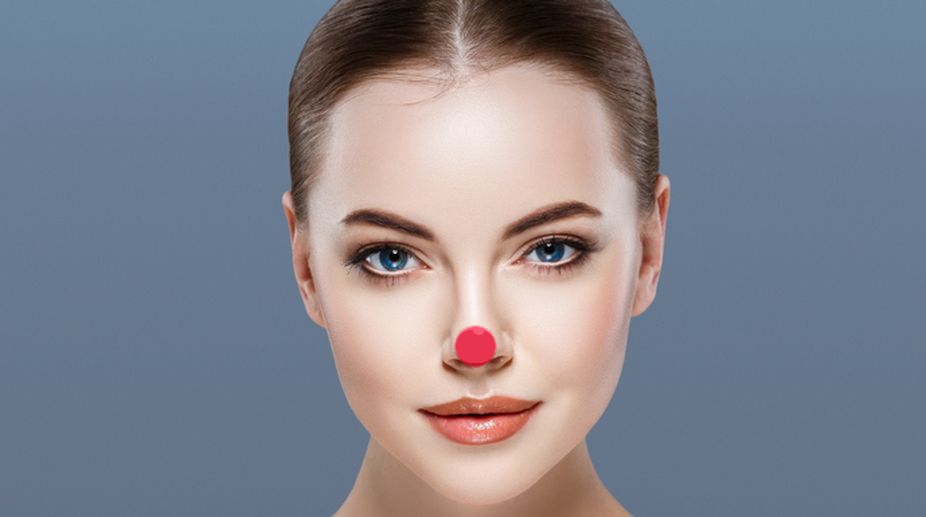

In [ ]:
nose_list=["/content/5.png", "/content/6.png",  "/content/8.png"] #list of noses
img = cv2.imread("/content/face.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face = detector(gray, 1)


for face in face:
  landmarks = predictor(gray, face)
  result_3 = add_nose(img, landmarks= landmarks, nose_list= nose_list)
  cv2_imshow(result_3)

#Add Mask

In [ ]:
  def add_mask(face_img, landmarks, mask_list):
      overlay_t_img  = cv2.imread(random.choice(mask_list), -1) # randomly selecting a nose image with transparent background      
      # Face co-ordinate  
      face_left = (landmarks.part(4).x, landmarks.part(4).y)  
      face_right = (landmarks.part(14).x, landmarks.part(14).y)  
      face_bottom = (landmarks.part(8).x, landmarks.part(8).y)
      lip_center = (landmarks.part(51).x, landmarks.part(51).y)
      mask_top = (landmarks.part(29).x, landmarks.part(29).y)
      mask_width = int(hypot(face_left[0] - face_right[0], face_left[1] - face_right[1]))
      mask_height = int((hypot(mask_top[0] - face_bottom[0], mask_top[1] - face_bottom[1] )))  
      roi_top_left =  (abs(int(lip_center[0] - mask_width/2)), abs(int(lip_center[1] - mask_height/2)))
      roi_bottom_right = (abs(int(lip_center[0] + mask_width/2)), abs(int(lip_center[1] + mask_height/2)))
      roi =  face_img[roi_top_left[1]: roi_top_left[1] + mask_height, roi_top_left[0]: roi_top_left[0]+mask_width]       
      overlay_t_img = cv2.resize(overlay_t_img, (roi.shape[1], roi.shape[0]))          
      # Split out the transparency mask from the colour info
      overlay_mask = overlay_t_img[: , : , 3:]  # Grab the alpha plane  
      overlay_img = overlay_t_img[: , : , :3] # Grab the BRG planes
      # Let's shrink and blur it a little to make the transitions smoother...
      overlay_mask = cv2.erode(overlay_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
      overlay_mask = cv2.blur(overlay_mask, (3, 3))          
      # Again calculate the inverse mask
      background_mask = 255 - overlay_mask            
      # Turn the masks into three channel, so we can use them as weights
      overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
      background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)        
      # Create a masked out face image, and masked out overlay
      # We convert the images to floating point in range 0.0 - 1.0
      face_part = face_part = (roi  * (background_mask * (1 / 255.0)))
      overlay_part = (overlay_img * (overlay_mask * (1 / 255.0)))    
      dst = cv2.add(face_part,overlay_part)
      face_img[roi_top_left[1]: roi_top_left[1] + mask_height, roi_top_left[0]: roi_top_left[0]+mask_width] = dst          
      return face_img
    # ==============================================================================

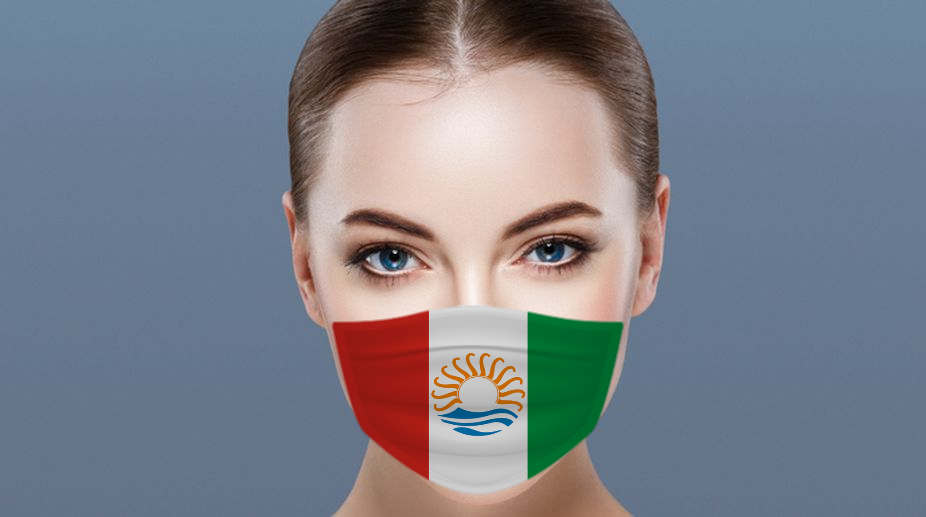

In [ ]:
mask_list=["/content/9.png"] # list of masks
img = cv2.imread("/content/face.jpg")

face = detector(img, 1)
for face in face:
  landmarks = predictor(img, face)
  result_4 = add_mask(img, landmarks= landmarks, mask_list= mask_list)
  cv2_imshow(result_4)